# KNN

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from datetime import datetime
import joblib
from sklearn.model_selection import train_test_split

數據預處理

In [7]:
# 數據預處理
input_path = '../dataSets'
train_data = pd.read_csv(os.path.join(input_path, "training.csv"))


分割出驗證集

In [8]:

train_data = train_data.drop(columns=["lettr"])

VALIDATE_SIZE = 0.3
RANDOM_SEED = 42
X_train, X_valid = train_test_split(train_data, test_size=VALIDATE_SIZE, random_state=RANDOM_SEED)

print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_valid.shape}""")




Shape of the datasets:
    training (rows, cols) = (2940, 16)
    validate (rows, cols) = (1260, 16)


正規化資料集

In [9]:

pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

pipeline.fit(X_train)

x_train = pipeline.transform(X_train)
x_valid = pipeline.transform(X_valid)

KKN training

In [10]:

# 記錄每次回合的結果
history = []


# 定義 Hyperopt 的目標函數
def objective(params):
    # 建立 KNN 模型
    model = NearestNeighbors(
        n_neighbors=int(params['n_neighbors']),  # 鄰居數量
        algorithm=params['algorithm'],  # 計算方法（auto, ball_tree, kd_tree, brute）
        metric=params['metric'],  # 距離度量方法（minkowski, euclidean, manhattan）
        leaf_size=params['leaf_size'],  # 設定葉子大小
        p=params['p']  # 曼哈頓距離的 p 值
    )
    
    
    model.fit(x_train)

    # 計算每筆 test 資料的異常分數（平均距離）
    distances, _ = model.kneighbors(x_valid)
    anomaly_scores = distances.mean(axis=1)

    val_loss = np.mean(anomaly_scores)


    # 記錄結果
    history.append({
        'n_neighbors': params['n_neighbors'],
        'metric': params['metric'],
        'leaf_size': params['leaf_size'],
        'algorithm': params['algorithm'],
        'p': params['p'],
        'loss': val_loss
    })

    # 如果是目前最佳，儲存當前參數與結果
    if val_loss < objective.best_loss:
        objective.best_loss = val_loss
        objective.best_params = params
        os.makedirs('../best_KNN', exist_ok=True)
        joblib.dump(model, '../best_KNN/best_knn_model.pkl')  # 儲存模型
        print(f"val_loss: {val_loss:.4f}")
        
    return {'loss': val_loss, 'status': STATUS_OK, 'params': params}



# 搜尋空間與初始化
objective.best_loss = float('inf')

space = {
    'n_neighbors': hp.choice('n_neighbors', [2, 3, 4, 5, 6, 7, 9, 10]),  # 鄰居數量
    'metric': hp.choice('metric', ['euclidean']),                        # 距離度量方式
    'leaf_size': hp.choice('leaf_size', [40, 45, 50]),                   # 設定葉子大小
    'algorithm': hp.choice('algorithm', ['auto', 'kd_tree']),            # 計算算法
    'p': hp.choice('p', [1, 2]),                                         # 距離計算的 p 值
}


# 執行超參數搜尋
trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=20, 
            trials=trials, 
            verbose=1, 
            show_progressbar=True
        )

# 輸出最佳結果
print("Best hyperparameters:", objective.best_params)
print("Best loss:", objective.best_loss)


val_loss: 0.2049                                      
val_loss: 0.1733                                      
 30%|███       | 6/20 [00:00<00:00, 23.29trial/s, best loss: 0.17334293252924776]

c:\Users\s1092\Desktop\HW02\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系統找不到指定的檔案。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(

  File "c:\Users\s1092\Desktop\HW02\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(

  File "C:\Users\s1092\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:

  File "C:\Users\s1092\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,

  File "C:\Users\s1092\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1435, in _execute_child
    hp, ht, pid, tid = _winap

val_loss: 0.1733                                                                 
100%|██████████| 20/20 [00:00<00:00, 24.91trial/s, best loss: 0.1733429317188267] 
Best hyperparameters: {'algorithm': 'kd_tree', 'leaf_size': 40, 'metric': 'euclidean', 'n_neighbors': 2, 'p': 2}
Best loss: 0.1733429317188267


繪製超參數和 loss 的關係圖

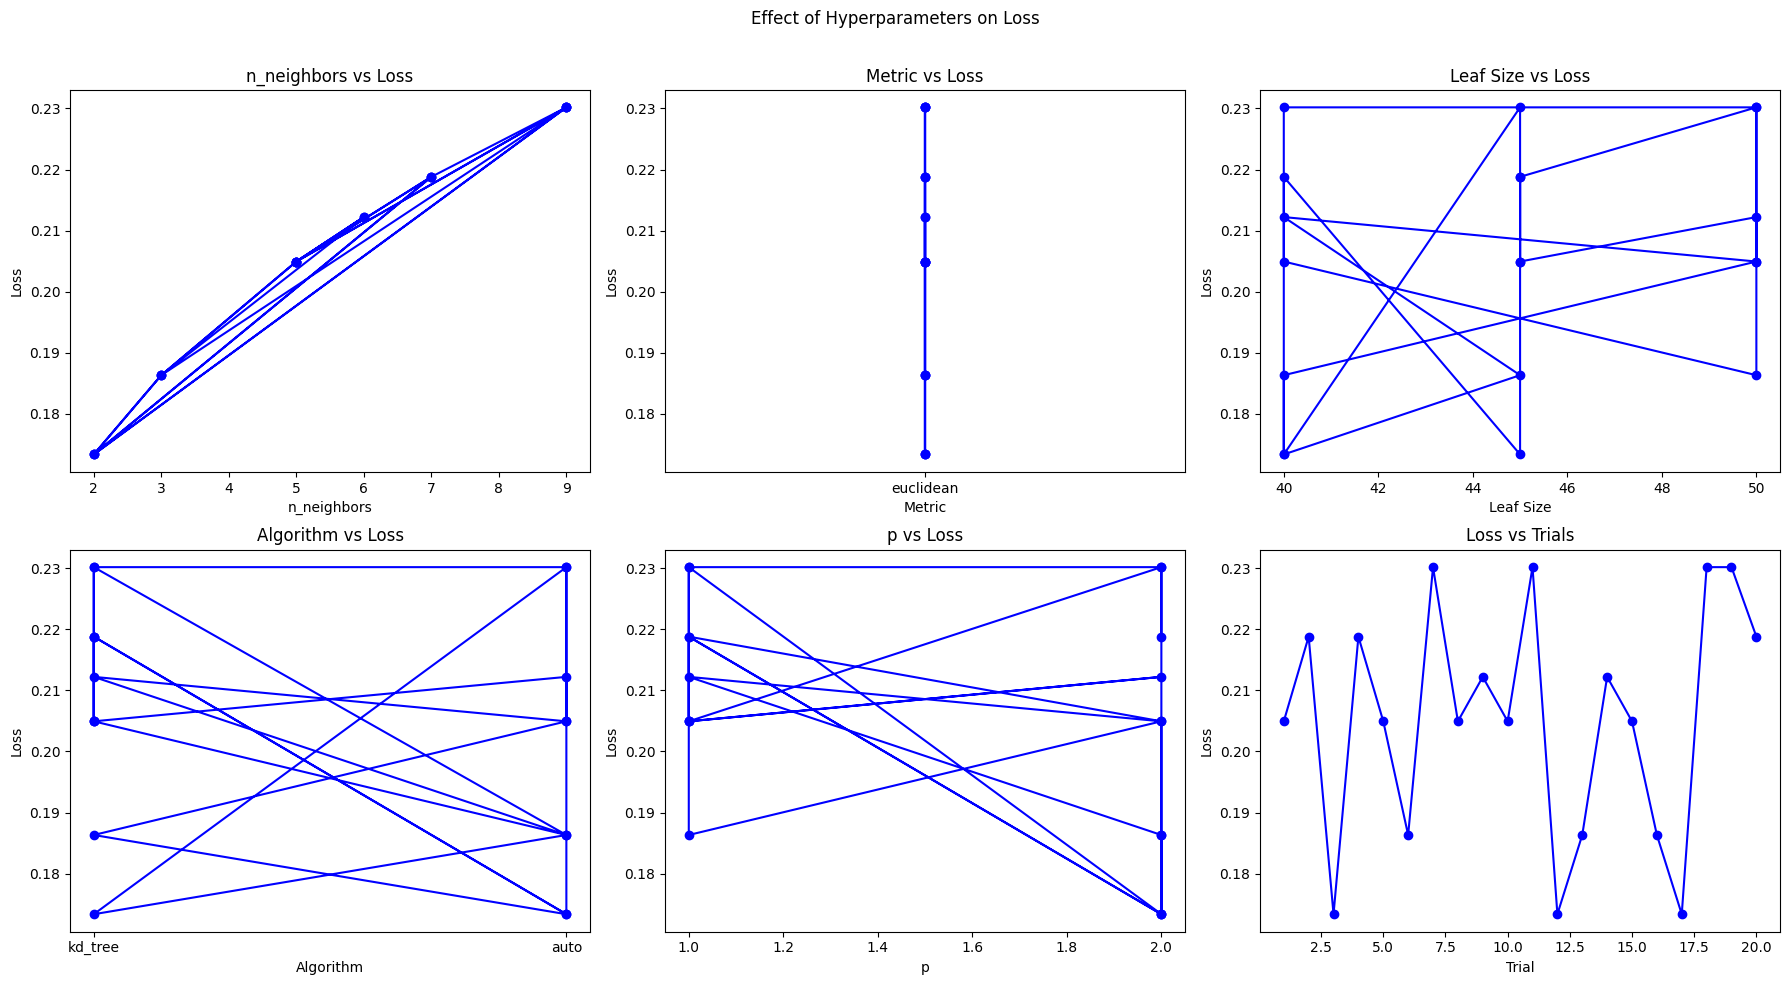

In [11]:
import matplotlib.pyplot as plt

# 繪製超參數和 loss 的關係圖
history_df = pd.DataFrame(history)

# 繪製每個超參數對 loss 的影響
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Effect of Hyperparameters on Loss")

# n_neighbors vs loss
axes[0, 0].plot(history_df['n_neighbors'], history_df['loss'], 'bo-')
axes[0, 0].set_title('n_neighbors vs Loss')
axes[0, 0].set_xlabel('n_neighbors')
axes[0, 0].set_ylabel('Loss')

# metric vs loss
axes[0, 1].plot(history_df['metric'], history_df['loss'], 'bo-')
axes[0, 1].set_title('Metric vs Loss')
axes[0, 1].set_xlabel('Metric')
axes[0, 1].set_ylabel('Loss')

# leaf_size vs loss
axes[0, 2].plot(history_df['leaf_size'], history_df['loss'], 'bo-')
axes[0, 2].set_title('Leaf Size vs Loss')
axes[0, 2].set_xlabel('Leaf Size')
axes[0, 2].set_ylabel('Loss')

# algorithm vs loss
axes[1, 0].plot(history_df['algorithm'], history_df['loss'], 'bo-')
axes[1, 0].set_title('Algorithm vs Loss')
axes[1, 0].set_xlabel('Algorithm')
axes[1, 0].set_ylabel('Loss')

# p vs loss
axes[1, 1].plot(history_df['p'], history_df['loss'], 'bo-')
axes[1, 1].set_title('p vs Loss')
axes[1, 1].set_xlabel('p')
axes[1, 1].set_ylabel('Loss')

# loss vs trials (number of evaluations)
axes[1, 2].plot(range(1, len(history_df) + 1), history_df['loss'], 'bo-')
axes[1, 2].set_title('Loss vs Trials')
axes[1, 2].set_xlabel('Trial')
axes[1, 2].set_ylabel('Loss')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

用全部的TrainDataSets 做training並儲存模型(可忽略)

In [12]:
# # 2. 數據預處理
# input_path = '../dataSets'
# train_data = pd.read_csv(os.path.join(input_path, "training.csv"))

# # 分割出驗證集
# X_train = train_data.drop(columns=["lettr"])

# # configure our pipeline
# pipeline = Pipeline([('normalizer', Normalizer()),
#                      ('scaler', MinMaxScaler())])

# pipeline.fit(X_train)

# x_train = pipeline.transform(X_train)

# params = {
#     'n_neighbors': hp.choice('n_neighbors', [2]),  # 鄰居數量
#     'metric': hp.choice('metric', ['euclidean']),  # 距離度量方式
#     'leaf_size': hp.choice('leaf_size', [44]),  # 設定葉子大小
#     'algorithm': hp.choice('algorithm', ['kd_tree']),  # 計算算法
#     'p': hp.choice('p', [2]),  # 距離計算的 p 值
# }

# model = NearestNeighbors(
#     n_neighbors=int(2),  # 鄰居數量
#     algorithm='kd_tree',  # 計算方法（auto, ball_tree, kd_tree, brute）
#     metric='euclidean',  # 距離度量方法（minkowski, euclidean, manhattan）
#     leaf_size=44,  # 設定葉子大小
#     p=2 # 曼哈頓距離的 p 值
# )

# model.fit(x_train)

# os.makedirs('../best_KNN', exist_ok=True)
# joblib.dump(model, '../best_KNN/best_knn_model.pkl')  # 儲存模型

Testing

In [14]:
# 2. 載入 test 資料並預處理
test_data = pd.read_csv(os.path.join("../dataSets", "test_X.csv"))
x_test = pipeline.transform(test_data)

# 3. 載入 KNN 模型
model = joblib.load('../best_KNN/best_knn_model.pkl')

# 4. 預測異常分數（平均距離）
distances, _ = model.kneighbors(x_test)
anomaly_scores = distances.mean(axis=1)

# 5. 輸出結果
test_loss = np.mean(anomaly_scores)
print(f"test_X.csv")
print(f"test_loss: {test_loss}")

results = pd.DataFrame({'id': test_data.index, 'outliers': anomaly_scores})
results.to_csv("../best_KNN/anomaly_detection_results.csv", index=False)

test_X.csv
test_loss: 0.26857933765034864
